In [1]:
!pip install opencv-python-headless networkx matplotlib


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


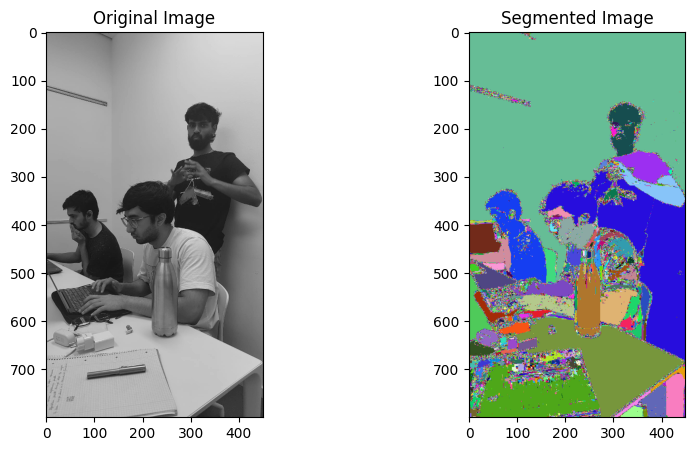

In [8]:
# Import necessary libraries
import cv2
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
from scipy.ndimage import zoom
import random

# Function to resize the image
def resize_image(image, scale_factor=0.5):
    return zoom(image, scale_factor)

# Function to build a graph from the image
def build_graph(image):
    rows, cols = image.shape
    G = nx.Graph()

    for x in range(rows):
        for y in range(cols):
            node = (x, y)
            G.add_node(node, intensity=image[x, y])
            if x > 0:  # Connect to the upper neighbor
                G.add_edge((x, y), (x-1, y), weight=abs(int(image[x, y]) - int(image[x-1, y])))
            if y > 0:  # Connect to the left neighbor
                G.add_edge((x, y), (x, y-1), weight=abs(int(image[x, y]) - int(image[x, y-1])))
    return G

# Union-Find Data Structure for Segment Management
class UnionFind:
    def __init__(self, n):
        self.parent = list(range(n))
        self.rank = [0] * n

    def find(self, u):
        if self.parent[u] != u:
            self.parent[u] = self.find(self.parent[u])
        return self.parent[u]

    def union(self, u, v):
        root_u = self.find(u)
        root_v = self.find(v)
        if root_u != root_v:
            if self.rank[root_u] > self.rank[root_v]:
                self.parent[root_v] = root_u
            elif self.rank[root_u] < self.rank[root_v]:
                self.parent[root_u] = root_v
            else:
                self.parent[root_v] = root_u
                self.rank[root_u] += 1

# Function to segment the image using the graph-based method
def segment_image(image, threshold):
    G = build_graph(image)
    num_nodes = len(G.nodes)
    uf = UnionFind(num_nodes)
    node_index = {node: idx for idx, node in enumerate(G.nodes)}
    index_node = {idx: node for node, idx in node_index.items()}

    edges = sorted(G.edges(data=True), key=lambda x: x[2]['weight'])

    for (u, v, d) in edges:
        if d['weight'] < threshold:
            uf.union(node_index[u], node_index[v])

    segments = {}
    for idx in range(num_nodes):
        root = uf.find(idx)
        if root not in segments:
            segments[root] = []
        segments[root].append(index_node[idx])

    segmented_image = np.zeros((*image.shape, 3), dtype=np.uint8)
    for color, (root, nodes) in zip(random.sample(range(1, 256*256*256), len(segments)), segments.items()):
        r = (color >> 16) & 255
        g = (color >> 8) & 255
        b = color & 255
        for (x, y) in nodes:
            segmented_image[x, y] = [r, g, b]

    return segmented_image

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load the image from Google Drive
image_path = '/content/drive/MyDrive/bike insurance/objects.jpg'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Resize the image to speed up computation
image_resized = resize_image(image, scale_factor=0.5)

# Segment the image
threshold = 5
segmented_image = segment_image(image_resized, threshold)

# Display the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image_resized, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Segmented Image")
plt.imshow(segmented_image)
plt.show()
